In [375]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
from queue import Queue

In [14]:
colors = ['r', 'g', 'b']

In [759]:
class Node:
    def __init__(self, data: int, x: float = None, y: float = None):
        self.data = data
        self.x = x or random.uniform(0.25, 1.7)
        self.y = y or random.uniform(0.25, 1.7)
        self.color = random.choices(colors)[0]
        self.radius = 0.1
        self.neighbours = []
        
    def view(self):
        # return plt.Circle((self.x, self.y), self.radius, color=self.color, fill=False)
        return plt.plot(self.x, self.y, 'ro')
        
    def __repr__(self):
        return f"<Nodo {self.data}>"

In [309]:
class Arista:
    def __init__(self, x, y, weight = None):
        self._x = x
        self._y = y
        self._weight = weight or None
        
    @property
    def x(self):
        return self._x
    
    @x.setter
    def x(self, value):
        self._x = value
        
    @property
    def y(self):
        return self._y
    
    @y.setter
    def y(self, value):
        self._y = value
        
    @property
    def weight(self):
        return self._weight
    
    @weight.setter
    def weight(self, value):
        self._weight = value
        
    def __repr__(self):
        return f"<Arista {self.x} - {self.y}>"

In [310]:
class BidirectialArista(Arista):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __repr__(self):
        return f"<BidirectialArista {(self._x, self._y)}>"
    
    
class UnidirectionalArista(Arista):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
    
    def __repr__(self):
        return f"<UnidirectionalArista {self._x} to {self._y}>"

In [754]:
class NodeArista:
    def __init__(self, y, weight = None):
        self._y = y
        self._weight = weight or None
        
    @property
    def y(self):
        return self._y
    
    @y.setter
    def y(self, value):
        self._y = value
        
    @property
    def weight(self):
        return self._weight
    
    @weight.setter
    def weight(self, value):
        self._weight = value
        
    def __eq__(self, other):
        if self.y == other.y:
            return True
        return False
        
    def __repr__(self):
        return f"<NodeArista to {self.y}>"

In [827]:
class Graph:
    def __init__(self):
        self._vertexes = []
        self._edges = []
        
    @property
    def vertexes(self):
        return self._vertexes
    
    @vertexes.setter
    def vertexes(self, value):
        self._vertexes = value
    
    @property
    def edges(self):
        return self._edges
    
    @edges.setter
    def edges(self, value):
        self._edges = value
    
    def add_edge(self, a_data, b_data, weight, edge_class: BidirectialArista):
        node_data = [node.data for node in self._vertexes]
        if a_data in node_data and b_data in node_data:
            a_node = self.search_vertex(a_data)
            b_node = self.search_vertex(b_data)
            self._edges.append(edge_class(a_node, b_node, weight=weight))
            if edge_class == BidirectialArista:
                if not b_node in [n.y for n in a_node.neighbours]:
                    a_node.neighbours.append(NodeArista(b_node, weight))
                if not a_node in [n.y for n in b_node.neighbours]:
                    b_node.neighbours.append(NodeArista(a_node, weight))
            elif edge_class == UnidirectionalArista:
                a_node.neighbours.append(NodeArista(b_node, weight))
        else:
            print('Esta intentado crear una conexión entre datos inexistentes.')
    
    def add_vertex(self, node):
        if not isinstance(node, Node):
            self._vertexes.append(Node(node))
        else:
            self._vertexes.append(node)
            
    def search_vertex(self, value):
        for node in self._vertexes:
            if node.data == value:
                return node
        
    def draw(self):
        fig, ax = plt.subplots()
        for node in self._vertexes:
            ax.add_artist(*node.view())
            ax.annotate(node.data, xy=(node.x, node.y+0.15), fontsize=16, ha="center", color=node.color)

        for edge in self._edges:
            dx = (edge.y.x - edge.x.x)
            dy = (edge.y.y - edge.x.y)
            if isinstance(edge, BidirectialArista):
                plt.plot([edge.x.x, edge.y.x], [edge.x.y, edge.y.y], 'k-')
                ax.text(x=(edge.x.x+edge.y.x)/2 + 0.05, y=(edge.x.y+edge.y.y)/2 + 0.05, s=str(edge.weight), fontsize=12)
            elif isinstance(edge, UnidirectionalArista):
                plt.arrow(edge.x.x, edge.x.y, dx, dy, length_includes_head=True,head_width=0.05, head_length=0.10, overhang=0.2)
                ax.text(x=(edge.x.x+edge.y.x)/2 + 0.05, y=(edge.x.y+edge.y.y)/2 + 0.05, s=str(edge.weight), fontsize=16)

        plt.axis([0,2,0,2])
        return fig
        
    def dijkstra(self, origin: int, get_history=False):
        history = []
        state = pd.DataFrame(index=[node.data for node in self._vertexes], data={'dv': [float('inf')] * len(self._vertexes), 'pv': [0] * len(self._vertexes), 'conoc': [False] * len(self._vertexes)})
        
        state.at[origin, 'dv'] = 0
        history.append(state)
        while False in state['conoc'].unique():
            not_visited_table = state[~state['conoc']]
            if not not_visited_table.empty:
                next_current_index = state[~state['conoc']][['dv']].idxmin()
                current = self.search_vertex(next_current_index[0])
            else:
                break
            
            for edge in current.neighbours:
                actual_distance = state.at[edge.y.data, 'dv']
                updated_d = state.at[current.data, 'dv'] + edge.weight

                if updated_d < actual_distance:
                    state.at[edge.y.data, 'dv'] = updated_d
                    state.at[edge.y.data, 'pv'] = current.data
            
            state.at[current.data, 'conoc'] = True
            history.append(deepcopy(state))

        if get_history:
            return state, history
        return state
    
    def shortest_path(self, origin, dest, table, show=False):
        path = [dest]
        current_node = table.at[dest, 'pv']
        while current_node != origin:
            path.append(current_node)
            current_node = table.at[current_node, 'pv']
        path.append(origin)
        
        if show:
            aux_g = self
            valid_edges = []
            for _to, _from in zip(range(0, len(path)-1), range(1, len(path))):
                print(path[_from], path[_to])
                for n, edge in enumerate(aux_g.edges):
                    if not (edge.x.data == path[_from] and edge.y.data == path[_to]):
                        continue
                    valid_edges.append(edge)
            aux_g.edges = valid_edges
            return path, aux_g
                        
        return path
    
    def search_edge(self, a, b):
        for edge in self._edges:
            if edge.x.data == a and edge.y.data == b:
                return edge
        print('search_edge, not founded: ', a, b)
    
    def prim(self, origin, get_history=False):
        history = []
        state = pd.DataFrame(index=[node.data for node in self._vertexes], data={'dv': [float('inf')] * len(self._vertexes), 'pv': [0] * len(self._vertexes), 'conoc': [False] * len(self._vertexes)})
        minimum_expansion = []
        
        state.at[origin, 'dv'] = 0
        history.append(state)
        while False in state['conoc'].unique():
            not_visited_table = state[~state['conoc']]
            if not not_visited_table.empty:
                next_current_index = state[~state['conoc']][['dv']].idxmin()
                current = self.search_vertex(next_current_index[0])
                
                w = state.at[current.data, 'pv']
                v = current.data
                if w != 0:
                    minimum_expansion.append(self.search_edge(a=w, b=v))
            else:
                break
            
            for edge in current.neighbours:
                actual_distance = state.at[edge.y.data, 'dv']
                updated_d = edge.weight

                if updated_d < actual_distance:
                    state.at[edge.y.data, 'dv'] = updated_d
                    state.at[edge.y.data, 'pv'] = current.data
            
            state.at[current.data, 'conoc'] = True
            history.append(deepcopy(state))
        
        prim_graph = Graph()
        prim_graph.vertexes = self._vertexes
        prim_graph.edges = minimum_expansion
        
        if get_history:
            return state, history, prim_graph
        return state, prim_graph

In [761]:
g = Graph()

In [762]:
coords = {
    1: {'x': 0.75, 'y': 1.75},
    2: {'x': 1.25, 'y': 1.75},
    3: {'x': 1.75, 'y': 1},
    4: {'x': 1.25, 'y': 0.25},
    5: {'x': 0.75, 'y': 0.25},
    6: {'x': 0.25, 'y': 1},
}

for i in range(1, 7):
    g.add_vertex(Node(data=i, x=coords[i]['x'], y=coords[i]['y']))
g.vertexes

[<Nodo 1>, <Nodo 2>, <Nodo 3>, <Nodo 4>, <Nodo 5>, <Nodo 6>]

In [763]:
g.add_edge(1,6,5, edge_class=UnidirectionalArista)
g.add_edge(1,5,10, edge_class=UnidirectionalArista)
g.add_edge(1,3,40, edge_class=UnidirectionalArista)

g.add_edge(2,4,5, edge_class=UnidirectionalArista)

g.add_edge(3,2,10, edge_class=UnidirectionalArista)
g.add_edge(3,5,5, edge_class=UnidirectionalArista)

g.add_edge(4,3,5, edge_class=UnidirectionalArista)

g.add_edge(5,4,20, edge_class=UnidirectionalArista)

g.add_edge(6,2,20, edge_class=UnidirectionalArista)
g.add_edge(6,5,10, edge_class=UnidirectionalArista)

In [764]:
final_state, history = g.dijkstra(1, get_history=True)

In [765]:
history[0]

,dv,pv,conoc
1,0.0,0,True
2,25.0,6,True
3,35.0,4,True
4,30.0,5,True
5,10.0,1,True
6,5.0,1,True


In [766]:
history[1]

,dv,pv,conoc
1,0.000000,0,True
2,inf,0,False
3,40.000000,1,False
4,inf,0,False
5,10.000000,1,False
6,5.000000,1,False


In [767]:
history[2]

,dv,pv,conoc
1,0.000000,0,True
2,25.000000,6,False
3,40.000000,1,False
4,inf,0,False
5,10.000000,1,False
6,5.000000,1,True


In [768]:
history[3]

,dv,pv,conoc
1,0.0,0,True
2,25.0,6,False
3,40.0,1,False
4,30.0,5,False
5,10.0,1,True
6,5.0,1,True


In [769]:
history[4]

,dv,pv,conoc
1,0.0,0,True
2,25.0,6,True
3,40.0,1,False
4,30.0,5,False
5,10.0,1,True
6,5.0,1,True


In [770]:
history[5]

,dv,pv,conoc
1,0.0,0,True
2,25.0,6,True
3,35.0,4,False
4,30.0,5,True
5,10.0,1,True
6,5.0,1,True


In [771]:
history[6]

,dv,pv,conoc
1,0.0,0,True
2,25.0,6,True
3,35.0,4,True
4,30.0,5,True
5,10.0,1,True
6,5.0,1,True


-------------------

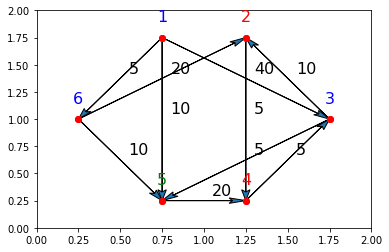

In [772]:
a = g.draw()

--------

In [773]:
path, aux_g = g.shortest_path(1, 3, final_state, show=True)

4 3
5 4
1 5


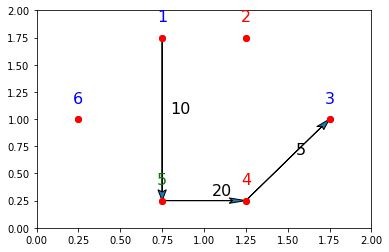

In [774]:
b = aux_g.draw()

In [775]:
aux_g.edges

[<UnidirectionalArista <Nodo 4> to <Nodo 3>>,
 <UnidirectionalArista <Nodo 5> to <Nodo 4>>,
 <UnidirectionalArista <Nodo 1> to <Nodo 5>>]

------------------
# Resources
- https://stackoverflow.com/questions/48847962/what-does-o-mean-in-matplotlibs-plot-function
    - Formatters para plt.plot()

In [828]:
g2 = Graph()

In [829]:
coords = {
    1: {'x': 1, 'y': 1.75},
    2: {'x': 0.25, 'y': 1},
    3: {'x': 1, 'y': 1},
    4: {'x': 1.75, 'y': 1},
    5: {'x': 0.75, 'y': 0.25},
    6: {'x': 1.25, 'y': 0.25},
}

for i in range(1, 7):
    g2.add_vertex(Node(data=i, x=coords[i]['x'], y=coords[i]['y']))
g2.vertexes

[<Nodo 1>, <Nodo 2>, <Nodo 3>, <Nodo 4>, <Nodo 5>, <Nodo 6>]

In [830]:
g2.add_edge(1,2,6, edge_class=BidirectialArista)
g2.add_edge(1,3,1, edge_class=BidirectialArista)
g2.add_edge(1,4,5, edge_class=BidirectialArista)

g2.add_edge(2,1,6, edge_class=BidirectialArista)
g2.add_edge(2,3,5, edge_class=BidirectialArista)
g2.add_edge(2,5,3, edge_class=BidirectialArista)

g2.add_edge(3,1,1, edge_class=BidirectialArista)
g2.add_edge(3,2,5, edge_class=BidirectialArista)
g2.add_edge(3,5,6, edge_class=BidirectialArista)
g2.add_edge(3,6,4, edge_class=BidirectialArista)
g2.add_edge(3,4,5, edge_class=BidirectialArista)

g2.add_edge(4,1,5, edge_class=BidirectialArista)
g2.add_edge(4,3,5, edge_class=BidirectialArista)
g2.add_edge(4,6,2, edge_class=BidirectialArista)

g2.add_edge(5,2,3, edge_class=BidirectialArista)
g2.add_edge(5,3,6, edge_class=BidirectialArista)
g2.add_edge(5,6,6, edge_class=BidirectialArista)

g2.add_edge(6,5,6, edge_class=BidirectialArista)
g2.add_edge(6,3,4, edge_class=BidirectialArista)
g2.add_edge(6,4,2, edge_class=BidirectialArista)

In [831]:
i = 2
print(g2.vertexes[i].data)
g2.vertexes[i].neighbours

3


[<NodeArista to <Nodo 1>>,
 <NodeArista to <Nodo 2>>,
 <NodeArista to <Nodo 5>>,
 <NodeArista to <Nodo 6>>,
 <NodeArista to <Nodo 4>>]

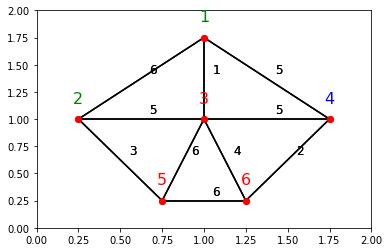

In [832]:
b = g2.draw()

In [833]:
state, history, prim_graph = g2.prim(1, get_history=True)

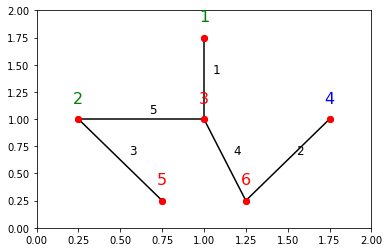

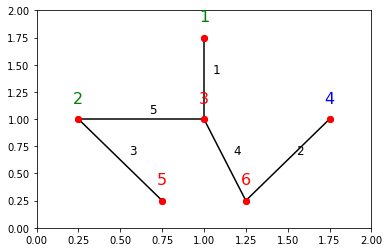

In [834]:
prim_graph.draw()

In [835]:
history[1]

,dv,pv,conoc
1,0.000000,0,True
2,6.000000,1,False
3,1.000000,1,False
4,5.000000,1,False
5,inf,0,False
6,inf,0,False


In [836]:
history[2]

,dv,pv,conoc
1,0.0,0,True
2,5.0,3,False
3,1.0,1,True
4,5.0,1,False
5,6.0,3,False
6,4.0,3,False


In [837]:
history[3]

,dv,pv,conoc
1,0.0,0,True
2,5.0,3,False
3,1.0,1,True
4,2.0,6,False
5,6.0,3,False
6,4.0,3,True
